In [1]:

!pip install -U pathway pandas numpy matplotlib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.6

In [2]:

# Dynamic Parking Pricing using Pathway (Updated)


import pathway as pw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [3]:
# Step 1: Define schema for the dataset
class RawSchema(pw.Schema):
    LastUpdatedDate:        str
    LastUpdatedTime:        str
    TrafficConditionNearby: str
    VehicleType:            str
    SystemCodeNumber:       str
    Occupancy:              int
    Capacity:               int
    QueueLength:            int
    IsSpecialDay:           int




In [4]:
# Step 2: Read CSV using Pathway (static mode)
raw = pw.io.csv.read(
    "dataset.csv",
    schema=RawSchema,
    mode="static"  # header is assumed
)



In [5]:
# Step 3: Feature Engineering using Pathway
traffic_map = {"low": 0, "medium": 1, "average": 1, "high": 2}
vehicle_map = {"car": 1.0, "bike": 0.8, "truck": 1.2}

data = raw.select(
    **raw,
    Timestamp=pw.apply(
        lambda date, time: pd.to_datetime(f"{date} {time}", format="%d-%m-%Y %H:%M:%S"),
        raw.LastUpdatedDate,
        raw.LastUpdatedTime
    ),
    TrafficEncoded=pw.apply(lambda t: traffic_map.get(t, 1), raw.TrafficConditionNearby),  # Safe mapping
    VehicleWeight=pw.apply(lambda v: vehicle_map.get(v, 1.0), raw.VehicleType)              # Safe mapping
)



In [6]:
# Step 4: Convert Pathway table to pandas DataFrame
keys, cols = pw.debug.table_to_dicts(data)
df = pd.DataFrame({col: pd.Series(vals) for col, vals in cols.items()})
df = df.sort_values("Timestamp").reset_index(drop=True)



In [7]:
# Step 5: Pricing Model Configuration
base_price = 10.0
alpha = 2.0
lambda_ = 0.5



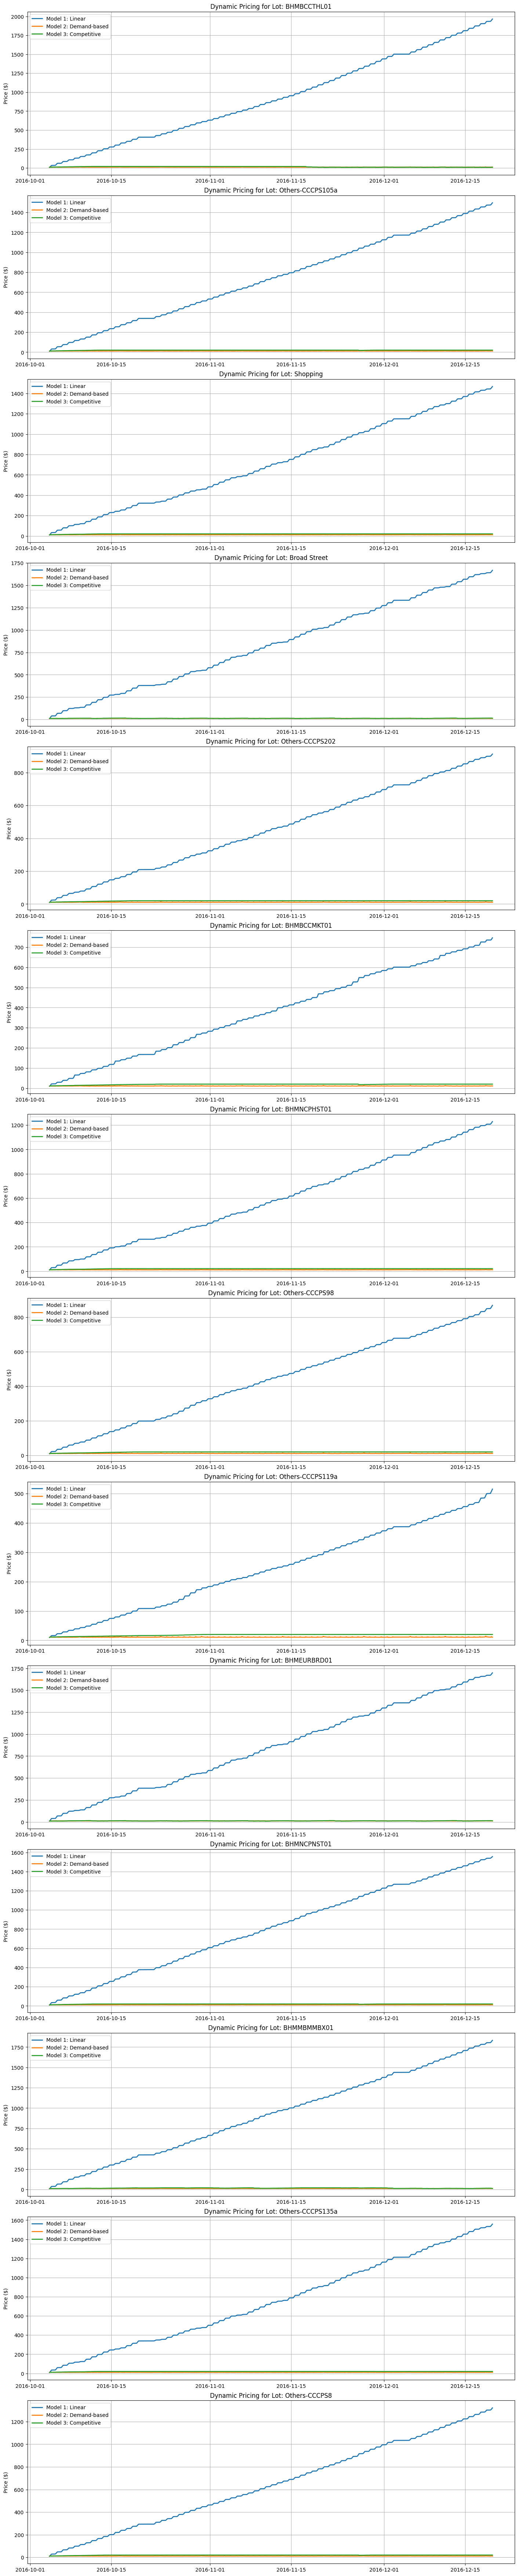

In [8]:
# Step 6: Loop through each parking lot and simulate prices
parking_lots = df['SystemCodeNumber'].unique()
fig, axs = plt.subplots(len(parking_lots), 1, figsize=(14, 5 * len(parking_lots)), constrained_layout=True)
if len(parking_lots) == 1:
    axs = [axs]

for idx, lot_id in enumerate(parking_lots):
    lot_df = df[df['SystemCodeNumber'] == lot_id].reset_index(drop=True)
    if len(lot_df) < 2:
        continue

    # Simulate competitor prices
    np.random.seed(42)
    competitor_prices = base_price * np.random.uniform(0.8, 1.2, size=len(lot_df))

    # Initialize price histories
    prices_model1 = [base_price]
    prices_model2 = [base_price]
    prices_model3 = [base_price]

    for i in range(1, len(lot_df)):
        occ = lot_df.loc[i, 'Occupancy']
        cap = lot_df.loc[i, 'Capacity']
        occ_ratio = occ / cap
        queue = lot_df.loc[i, 'QueueLength']
        traffic = lot_df.loc[i, 'TrafficEncoded']
        is_special = lot_df.loc[i, 'IsSpecialDay']
        v_weight = lot_df.loc[i, 'VehicleWeight']

        # --- Model 1: Linear Occupancy ---
        prev_price1 = prices_model1[-1]
        new_price1 = prev_price1 + alpha * occ_ratio
        prices_model1.append(new_price1)

        # --- Model 2: Demand-Based ---
        a, b, g, d, e = 1.0, 0.5, 0.5, 1.0, 0.3
        demand = a * occ_ratio + b * queue - g * traffic + d * is_special + e * v_weight
        norm_demand = demand / 10
        price2 = base_price * (1 + lambda_ * norm_demand)
        price2 = max(min(price2, 2 * base_price), 0.5 * base_price)
        prices_model2.append(price2)

        # --- Model 3: Competitive ---
        prev_price3 = prices_model3[-1]
        competitor_price = competitor_prices[i]
        if occ_ratio > 0.9 and competitor_price < prev_price3:
            price3 = prev_price3 - 0.5
        elif competitor_price > prev_price3:
            price3 = prev_price3 + 0.3
        else:
            price3 = prev_price3 + 0.1 * occ_ratio
        price3 = max(min(price3, 2 * base_price), 0.5 * base_price)
        prices_model3.append(price3)

    # Plot the results
    axs[idx].plot(lot_df['Timestamp'], prices_model1, label='Model 1: Linear', linewidth=2)
    axs[idx].plot(lot_df['Timestamp'], prices_model2, label='Model 2: Demand-based', linewidth=2)
    axs[idx].plot(lot_df['Timestamp'], prices_model3, label='Model 3: Competitive', linewidth=2)
    axs[idx].set_title(f"Dynamic Pricing for Lot: {lot_id}")
    axs[idx].set_ylabel("Price ($)")
    axs[idx].legend()
    axs[idx].grid(True)



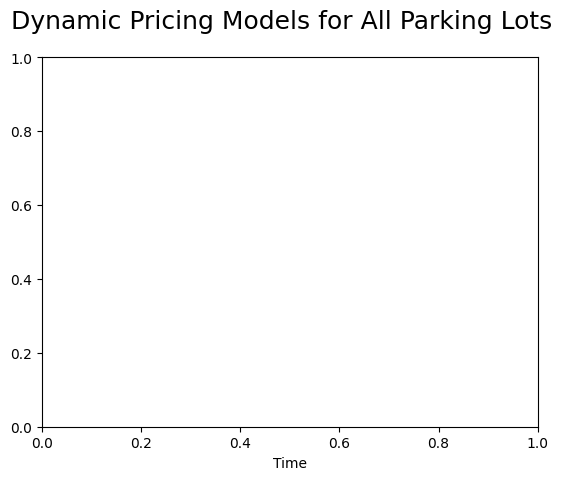

In [9]:
plt.suptitle("Dynamic Pricing Models for All Parking Lots", fontsize=18)
plt.xlabel("Time")
plt.show()